# Stellar Parameters from Spectra & Distance

Estimate a star's effective temperature and radius by fitting a blackbody to a flux-calibrated spectrum
and using the distance (from parallax) to convert the fitted scale to a physical radius.


## Theory (short)

Observed flux: $F_\lambda(\lambda) = \pi B_\lambda(\lambda, T) (R/d)^2$.
Fit for $T$ and scale $S=\pi(R/d)^2$. Then $R = d\sqrt{S/\pi}$.


In [1]:
# Planck and fitting helper functions
from scipy.constants import h, c, k
def planck_lambda(wl_m, T):
    a = 2.0*h*c**2 / (wl_m**5)
    b = np.exp((h*c) / (wl_m*k*T)) - 1.0
    return a / b
def observed_flux_model(wl_m, T, S):
    return S * planck_lambda(wl_m, T)
def angstrom_to_m(x):
    return x * 1e-10


## Synthetic example — recover T and R
This cell simulates a blackbody spectrum with known T, R, distance, adds noise, fits for T and S, and recovers R.

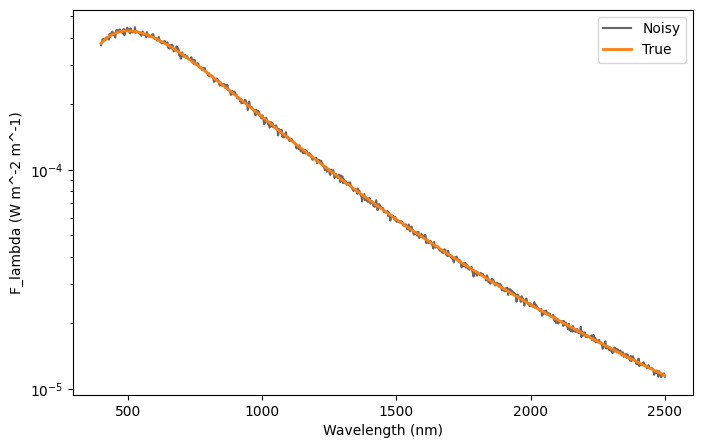

Fitted T = 5806.5 ± 5.2 K
Recovered R = 0.998 R_sun (true 1.000)


In [2]:
# Synthetic example (copy into your notebook to run)
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
pc_to_m = 3.085677581491367e16

T_true = 5800.0
R_true = 1.0 * 6.957e8
d_pc = 10.0
d_m = d_pc * pc_to_m

wl_nm = np.linspace(400, 2500, 800)
wl_m = wl_nm * 1e-9
B_true = planck_lambda(wl_m, T_true)
S_true = np.pi * (R_true/d_m)**2
F_true = S_true * B_true
rng = np.random.default_rng(123)
noise_level = 0.02
F_noisy = F_true * (1 + noise_level * rng.normal(size=F_true.size))

plt.figure(figsize=(8,5))
plt.plot(wl_nm, F_noisy, color='k', alpha=0.6, label='Noisy')
plt.plot(wl_nm, F_true, color='C1', lw=2, label='True')
plt.yscale('log')
plt.xlabel('Wavelength (nm)'); plt.ylabel('F_lambda (W m^-2 m^-1)')
plt.legend(); plt.show()

mask = (wl_nm > 450) & (wl_nm < 2000)
wl_fit = wl_m[mask]
F_fit = F_noisy[mask]
sigma = np.abs(F_fit) * noise_level
p0 = [5500.0, S_true*0.8]
popt, pcov = curve_fit(observed_flux_model, wl_fit, F_fit, p0=p0, sigma=sigma, absolute_sigma=True, maxfev=20000)
T_fit, S_fit = popt
T_err, S_err = np.sqrt(np.diag(pcov))
print(f'Fitted T = {T_fit:.1f} ± {T_err:.1f} K')
R_fit_m = d_m * np.sqrt(S_fit/np.pi)
print(f'Recovered R = {R_fit_m/6.957e8:.3f} R_sun (true {R_true/6.957e8:.3f})')


## Applying to a real FITS spectrum

If you have a flux-calibrated spectrum in FITS format, convert flux to W m^-2 m^-1 and wavelength to meters, then run the same fit.
Be careful with units and calibration.

In [3]:
# Example loader (user supplies path)
from astropy.io import fits
fits_path = ''  # <-- set this to your flux-calibrated 1D FITS spectrum
if fits_path:
    hdul = fits.open(fits_path)
    data = hdul[1].data
    wave_ang = data['wavelength']
    flux_erg = data['flux']
    flux_SI = flux_erg * 1e-7 / 1e-4 / 1e-10
    wl_m = wave_ang * 1e-10
    # then run curve_fit(observed_flux_model, wl_m, flux_SI, ...)
else:
    print('Set fits_path to your observed FITS file.')


Set fits_path to your observed FITS file.


## Notes & Extensions

- Real spectra are not perfect blackbodies; for accurate T and log(g) use synthetic spectral libraries (PHOENIX, Kurucz) and chi-square fitting or MCMC.
- Convert parallax to distance with care; for large relative parallax errors use Bayesian distances.
- Next module idea: stellar structure ODE solver (Lane–Emden) or spectral fitting with PHOENIX grids.


**Propagate parallax uncertainty → radius uncertainty**

Generate synthetic star spectrum

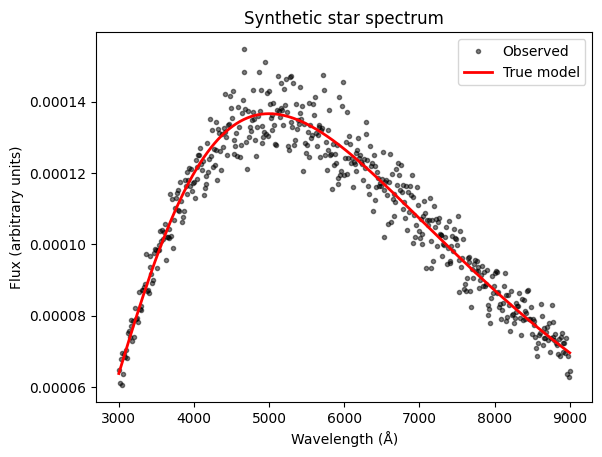

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Create synthetic data for a star
T_true = 5800  # K
R_true = 1.0   # Rsun
d_true = 10.0  # pc

# Constants
h = 6.626e-34
c = 3.0e8
kB = 1.381e-23
Rsun_m = 6.96e8
pc_m = 3.086e16

def planck_lambda(lam, T):
    lam_m = lam * 1e-10
    return (2*h*c**2 / lam_m**5) / (np.exp(h*c/(lam_m*kB*T)) - 1.0)

# Wavelength grid (Å)
wave = np.linspace(3000, 9000, 500)
flux_true = planck_lambda(wave, T_true)

# Scale by (R/d)^2
scale_true = (R_true * Rsun_m / (d_true * pc_m))**2
flux_scaled = flux_true * scale_true

# Add noise
rng = np.random.default_rng(42)
flux_obs = flux_scaled * (1 + 0.05 * rng.normal(size=len(wave)))

plt.plot(wave, flux_obs, 'k.', alpha=0.5, label="Observed")
plt.plot(wave, flux_scaled, 'r-', lw=2, label="True model")
plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux (arbitrary units)")
plt.legend()
plt.title("Synthetic star spectrum")
plt.show()


Fit blackbody model and recover 
𝑇
T and 
𝑅
/
𝑑
R/d

In [9]:
from scipy.optimize import curve_fit

def planck_lambda_scaled(lam, T, scale):
    lam_m = lam * 1e-10
    return scale * (2*h*c**2 / lam_m**5) / (np.exp(h*c/(lam_m*kB*T)) - 1.0)

popt, pcov = curve_fit(planck_lambda_scaled, wave, flux_obs, p0=[6000, 1e-19])
best_T, best_scale = popt

# Convert scaling factor into R/d (dimensionless, Rsun/pc)
Rsun_over_pc = Rsun_m / pc_m
best_R_over_d = np.sqrt(best_scale) / Rsun_over_pc

print(f"Best-fit T = {best_T:.0f} K")
print(f"(R/d) = {best_R_over_d:.3e} Rsun/pc")


Best-fit T = 5794 K
(R/d) = 1.002e-01 Rsun/pc


Propagate parallax uncertainty → radius

In [10]:
# Example Gaia parallax
parallax_mas = 25.0      # mas (40 pc)
parallax_err_mas = 0.1   # mas

# Distance in pc
d_pc = 1000.0 / parallax_mas
d_err_pc = (1000.0 / (parallax_mas**2)) * parallax_err_mas

print(f"Distance = {d_pc:.2f} ± {d_err_pc:.2f} pc")

# Radius estimate
R_star = best_R_over_d * d_pc
R_star_err = best_R_over_d * d_err_pc

print(f"Radius = {R_star:.2f} ± {R_star_err:.2f} Rsun")


Distance = 40.00 ± 0.16 pc
Radius = 4.01 ± 0.02 Rsun
